<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/Ariadne%2B_wire_segmentation_%2B_masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lar-unibo/ariadne_plus.git
%cd ariadne_plus

Cloning into 'ariadne_plus'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 77 (delta 7), reused 11 (delta 1), pack-reused 55 (from 1)
Receiving objects: 100% (77/77), 46.69 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/ariadne_plus


In [3]:
!pip install pytorch-lightning==1.4.2
!pip install segmentation-models-pytorch
!pip install timm
!pip install albumentations
!pip install opencv-python
!pip install matplotlib

  Using cached pytorch_lightning-1.4.2-py3-none-any.whl.metadata (32 kB)
  Using cached torchmetrics-1.7.2-py3-none-any.whl.metadata (21 kB)
  Using cached pyDeprecate-0.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached n

In [4]:
%pwd

'/content/ariadne_plus'

In [5]:
%%writefile requirements.txt
torch
torchvision
torchaudio
opencv-python
scikit-image
matplotlib
tqdm
pyyaml

Writing requirements.txt


In [6]:
!pip install -r requirements.txt

In [49]:
!pip install torchmetrics==0.11.4 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.6 MB/s eta 0:00:00


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!mkdir -p scripts/checkpoints
!cp "/content/drive/MyDrive/Colab Notebooks/deeplab.pth" scripts/checkpoints/model_deeplab.pth

In [19]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/backbone/resnet.py

In [21]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/_deeplab.py

In [23]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/backbone/mobilenetv2.py

In [24]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from scripts.core import deeplabv3plus_resnet101, convert_to_separable_conv
from scripts.utils.dataset import BasicDataset

# Load model
model = deeplabv3plus_resnet101(num_classes=1, output_stride=16)
convert_to_separable_conv(model.classifier)
checkpoint = torch.load("scripts/checkpoints/model_deeplab.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 232MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [25]:
from google.colab import files
uploaded = files.upload()

Saving simple_0.jpg to simple_0.jpg


In [26]:
img = cv2.imread("simple_0.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_pre = torch.from_numpy(BasicDataset.pre_process(img_rgb)).unsqueeze(0).float()

with torch.no_grad():
    output = model(img_pre)
    mask = torch.sigmoid(output).squeeze().numpy()

mask_bin = (mask > 0.5).astype(np.uint8) * 255

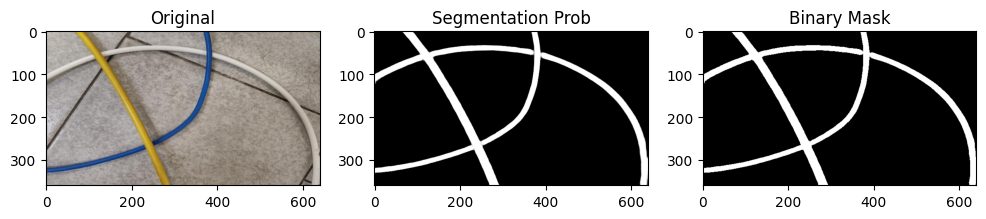

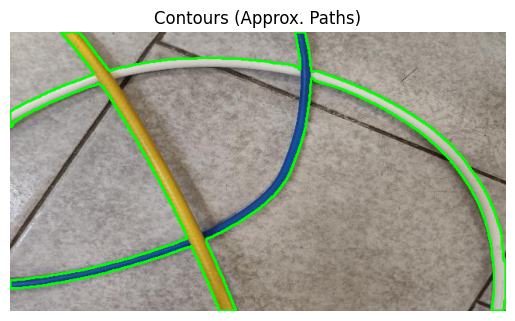

In [27]:
# Show segmentation result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Prob")

plt.subplot(1, 3, 3)
plt.imshow(mask_bin, cmap='gray')
plt.title("Binary Mask")
plt.show()

# Contour visualization
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

plt.imshow(contour_img)
plt.title("Contours (Approx. Paths)")
plt.axis('off')
plt.show()


In [53]:
import cv2

# Save binary mask image
cv2.imwrite("wire_mask.png", img_mask)


True

In [29]:
img = cv2.imread('simple_0.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Simulated binary mask (e.g., edges or thresholding for demo)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)


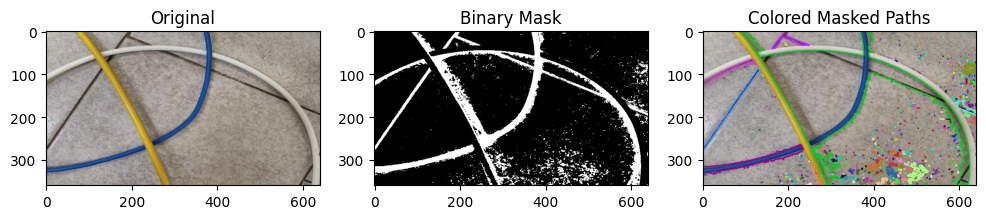

In [30]:
# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw on top of original
colored_result = img_rgb.copy()
for i, cnt in enumerate(contours):
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    cv2.drawContours(colored_result, [cnt], -1, color, thickness=2)

# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_result)
plt.title("Colored Masked Paths")
plt.show()


In [46]:
!pip install arrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.5 MB/s eta 0:00:00


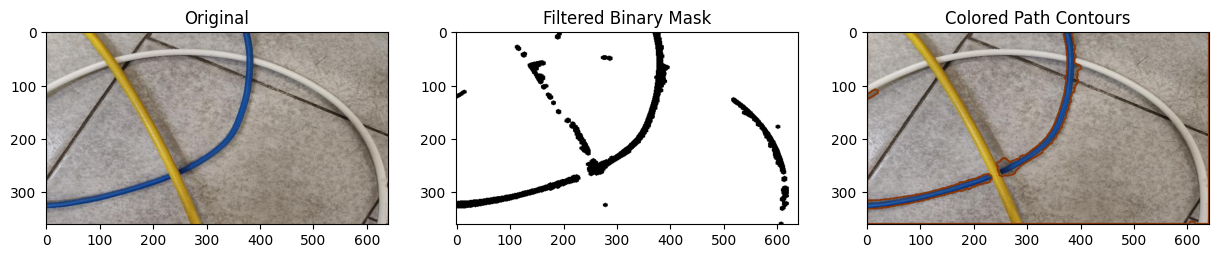

In [34]:
# Convert to grayscale and apply normal threshold (not inverted)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary_mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

# Morphological operations to reduce noise and connect broken paths
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Keep only large white areas (filter small white blobs)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_mask, connectivity=8)
min_area = 1000  # Try 1000 or 1500
filtered_mask = np.zeros_like(closed_mask)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_mask[labels == i] = 255
# 3. Contour detection & color overlay
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

colored_result = img_rgb.copy()
for cnt in contours:
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.drawContours(colored_result, [cnt], -1, color, 2)

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(filtered_mask, cmap='gray')
plt.title("Filtered Binary Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_result)
plt.title("Colored Path Contours")
plt.show()

In [35]:
!pip install opencv-contrib-python

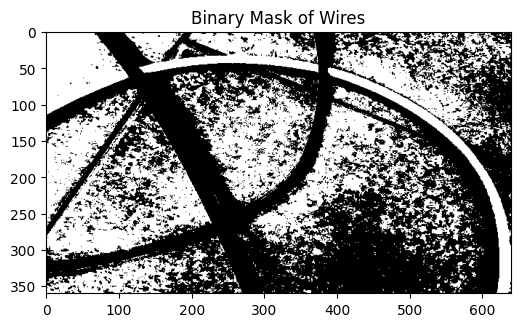

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and convert image
img = cv2.imread('simple_0.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Step 2: Create a mask for bright objects (wires)
lower_white = np.array([0, 0, 160])
upper_white = np.array([180, 80, 255])
img_mask = cv2.inRange(hsv, lower_white, upper_white)  # white and bright

# (Optional) Show the binary mask
plt.figure(figsize=(6, 4))
plt.imshow(img_mask, cmap='gray')
plt.title("Binary Mask of Wires")
plt.show()




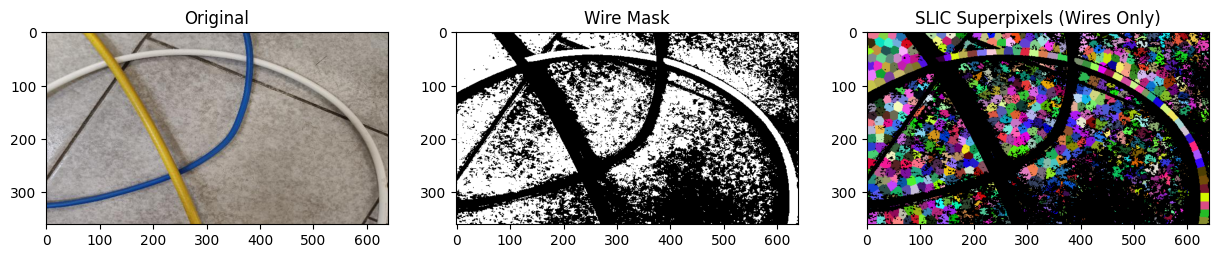

In [52]:
# Apply SLIC only on masked area
masked_img = cv2.bitwise_and(img, img, mask=img_mask)

slic = cv2.ximgproc.createSuperpixelSLIC(masked_img, algorithm=cv2.ximgproc.SLICO, region_size=15, ruler=10.0)
slic.iterate(10)
slic.enforceLabelConnectivity(min_element_size=25)

labels = slic.getLabels()
mask = slic.getLabelContourMask()

# Mask out background from superpixel color result
mask_inv = cv2.bitwise_not(mask)
colored_spx = np.zeros_like(img_rgb)
num_spx = slic.getNumberOfSuperpixels()
for i in range(num_spx):
    colored_spx[labels == i] = np.random.randint(0, 255, 3)
colored_spx = cv2.bitwise_and(colored_spx, colored_spx, mask=img_mask)

# Display
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(img_mask, cmap='gray')
plt.title("Wire Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_spx)
plt.title("SLIC Superpixels (Wires Only)")
plt.show()


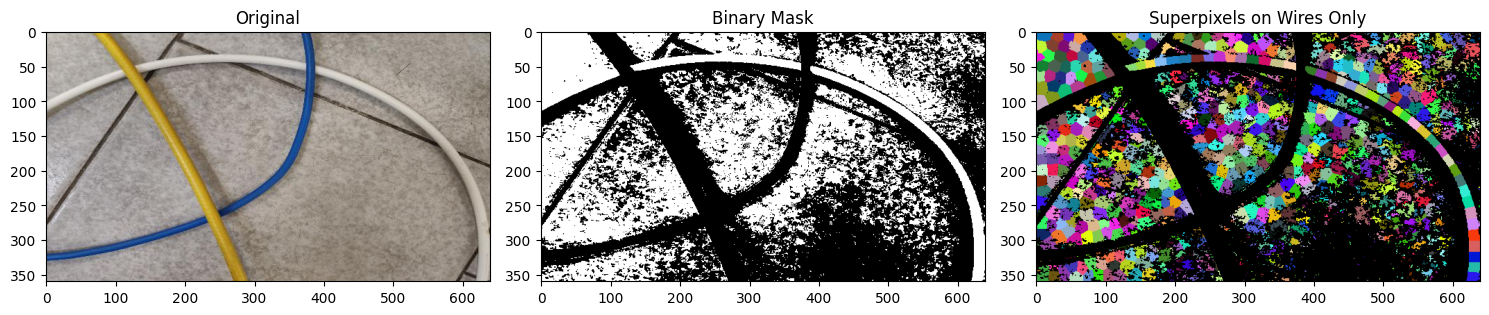

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image and mask
img = cv2.imread('simple_0.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Your binary mask: white wires (255), background (0)
# For demo: assume already loaded as `img_mask`
# You can also load manually if needed:
# img_mask = cv2.imread('mask.png', 0)

# Step 1: Apply mask to image (wires only)
masked_img = cv2.bitwise_and(img, img, mask=img_mask)

# Step 2: Apply SLIC only on masked area
slic = cv2.ximgproc.createSuperpixelSLIC(masked_img, algorithm=cv2.ximgproc.SLICO, region_size=15, ruler=10.0)
slic.iterate(10)
slic.enforceLabelConnectivity(min_element_size=25)

labels = slic.getLabels()
mask = slic.getLabelContourMask()

# Step 3: Remove background superpixels using original mask
mask_inv = cv2.bitwise_not(mask)
masked_result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_inv)

# Color each wire-region superpixel
colored_spx = np.zeros_like(img_rgb)
num_spx = slic.getNumberOfSuperpixels()
for i in range(num_spx):
    colored_spx[labels == i] = np.random.randint(0, 255, 3)

# Mask out non-wire region from colored superpixels
colored_spx = cv2.bitwise_and(colored_spx, colored_spx, mask=img_mask)

# Step 4: Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(img_mask, cmap='gray')
plt.title("Binary Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_spx)
plt.title("Superpixels on Wires Only")
plt.tight_layout()
plt.show()

